In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms

mnist_folder = '/Users/ppx/Downloads/TP/data'

train_data = datasets.MNIST(root=mnist_folder, download=True, transform=transforms.ToTensor(), train=True)
test_data = datasets.MNIST(root=mnist_folder, download=True, transform=transforms.ToTensor(), train=False)

In [5]:
print("Nombre d'images dans le train set:", len(train_data))
print("Nombre d'images dans le train set:", len(test_data))



Nombre d'images dans le train set: 60000
Nombre d'images dans le train set: 10000


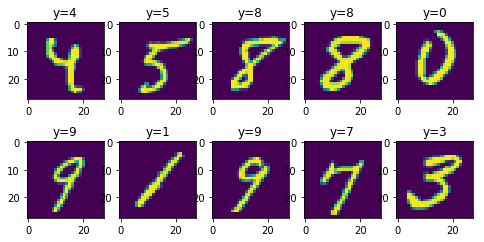

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 4), squeeze=False)
seed = 123 # changer la seed pour afficher d'autres images

for i in range(10):
    r = i // 5
    c = i % 5
    np.random.seed(seed+i)
    idx = np.random.choice(len(train_data), 1)[0]
    x = train_data[idx][0].numpy()
    y = train_data[idx][1]
    axes[r, c].imshow(x[0, :, :])
    axes[r, c].set_title('y={}'.format(y))
    
plt.show()

/Users/ppx/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


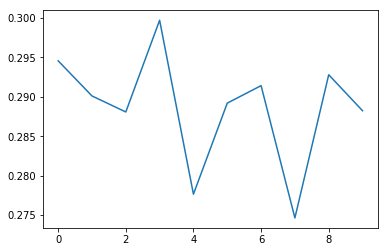

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import itertools


# Training settings
seed = 1337
#lr = 0.1
lrs = [0.1]#, 0.01, 0.001]
#epochs = 25
epochss = [10]#, 25, 50]
#train_batch_size = 50
train_batch_sizes = [10]#, 50]
test_batch_size = 100


result = []
for lr, epochs, train_batch_size in itertools.product(lrs, epochss, train_batch_sizes):
    torch.manual_seed(seed)

    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(28*28, 10)

        def forward(self, X):
            X = X.view(-1, 28*28)  # flatten images
            X = self.fc1(X)
            return F.log_softmax(X)

    model = Net()

    optimizer = optim.SGD(model.parameters(), lr=lr)

    def train(epoch):

        exp_loss = 0.
        n_processed = 0

        model.train()
        for X, Y in train_loader:
            X, Y = Variable(X), Variable(Y)

            # Forward pass
            Y_pred_prob = model(X)

            # Compute expected loss
            #loss = F.nll_loss(Y_pred_prob, Y)
            #L1Loss, MSELoss, 
            #CrossEntropyLoss, PoissonNLLLoss, 
            #KLDivLoss, BCELoss,
            #BCEWithLogitsLoss, TripletMarginLoss
            loss = F.nll_loss(Y_pred_prob, Y)

            # Backward pass
            loss.backward()

            # Parameter update (gradient descent)
            optimizer.step()
            optimizer.zero_grad()

            # exp_loss.data[0] += loss * X.data.shape[0]
            exp_loss += loss * X.data.shape[0]
            n_processed += X.data.shape[0]

        exp_loss /= n_processed
        return exp_loss

    def test():
        test_loss = 0
        test_error = 0

        model.eval()
        for X, Y in test_loader:
            X, Y = Variable(X, volatile=True), Variable(Y)

            # Forward pass
            Y_pred_prob = model(X)

            # Compute the expected negative log-likelihood
            test_loss += F.nll_loss(Y_pred_prob, Y, size_average=False).data[0]

            # Get the mode of p(y|x) (most probable digit)
            Y_pred = Y_pred_prob.data.max(1, keepdim=True)[1]

            # Compute the expected 0/1 error
            test_error += (1 - Y_pred.eq(Y.data.view_as(Y_pred))).sum()

        test_loss /= len(test_loader.dataset)
        test_error /= len(test_loader.dataset)

        return test_loss, test_error

    error = []
    for epoch in range(1, epochs + 1):



        train_loss = train(epoch)
        #print('Train negative log-likelihood: {:.6f}'.format(train_loss.data[0]))

        test_loss, test_error = test()
        error.append(test_loss)
        #print('Test  negative log-likelihood: {:.6f} 0/1 error: {:.6f}'.format(test_loss, test_error))
    result.append([lr, epochs, train_batch_size, test_loss])

    plt.plot(error)
    plt.show()
    plt.close()

# Amélirorations

In [42]:
torch.manual_seed(seed)

lr = 0.1
epochs = 2
train_batch_size = 2

train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

n_d = 2
ks = 5

In [43]:
class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv1pool= nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv2pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5*5*16, 10)
        #self.fc2 = nn.Linear(120, 10)
        #self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1pool(self.conv1(X)))
        X = F.relu(self.conv2pool(self.conv2(X)))
        X = X.view(-1, 5*5*16)
        
        #X = X.view(-1, 240)
        #X = F.relu(self.fc1(X))
        
        #X = F.dropout(X, training=self.training)
        X = self.fc1(X)
        #X = F.sigmoid(self.fc2(X))
        #X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [44]:
class Net01(nn.Module):
    def __init__(self):
        super(Net01, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        #self.conv1pool= nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv2pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(352, 10)
        #self.fc2 = nn.Linear(120, 10)
        #self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2pool(self.conv2(X)))
        X = X.view(-1, 352)
        X = self.fc1(X)

        return F.log_softmax(X, dim=1)

In [45]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1pool= nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, kernel_size=3)
        self.conv2pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 10)
        #self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1pool(self.conv1(X)))
        X = F.relu(self.conv2pool(self.conv2(X)))
        X = X.view(-1, 5*5*16)
        
        #X = X.view(-1, 240)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, training=self.training)
        X = self.fc2(X)
        #X = F.sigmoid(self.fc2(X))
        #X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    

In [46]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=4)
        self.conv1pool= nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv2pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5*5*14, 120)
        self.fc2 = nn.Linear(120, 10)
        #self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1pool(self.conv1(X)))
        X = F.relu(self.conv2pool(self.conv2(X)))
        X = X.view(-1, 5*5*14)
        
        #X = X.view(-1, 240)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, training=self.training)
        X = self.fc2(X)
        #X = F.sigmoid(self.fc2(X))
        #X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    

In [47]:
model = Net2()

ROMAIN CANDY

In [48]:
def train(epoch):

    exp_loss = 0.
    n_processed = 0

    model.train()
    for X, Y in train_loader:
        X, Y = Variable(X), Variable(Y)
        
        # Forward pass
        Y_pred_prob = model(X)
        
        # Compute expected loss
        loss = F.nll_loss(Y_pred_prob, Y)
        
        # Backward pass
        loss.backward()
        
        # Parameter update (gradient descent)
        optimizer.step()
        optimizer.zero_grad()

        # exp_loss.data[0] += loss * X.data.shape[0]
        exp_loss += loss * X.data.shape[0]
        n_processed += X.data.shape[0]
    
    exp_loss /= n_processed
    return exp_loss

def test():
    test_loss = 0
    test_error = 0
    
    model.eval()
    for X, Y in test_loader:
        X, Y = Variable(X, volatile=True), Variable(Y)
        
        # Forward pass
        Y_pred_prob = model(X)
        
        # Compute the expected negative log-likelihood
        test_loss += F.nll_loss(Y_pred_prob, Y, size_average=False).data[0]
        
        # Get the mode of p(y|x) (most probable digit)
        Y_pred = Y_pred_prob.data.max(1, keepdim=True)[1]
        
        # Compute the expected 0/1 error
        test_error += (1 - Y_pred.eq(Y.data.view_as(Y_pred))).sum()

    test_loss /= len(test_loader.dataset)
    test_error /= len(test_loader.dataset)

    return test_loss, test_error




In [ ]:
optimizer = optim.SGD(model.parameters(), lr=lr)
#optimizer = optim.Adamax(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=5, factor=.1)

#for epoch in range(1, epochs + 1):
epoch = 1
limit_epoch = 200
while (optimizer.param_groups[0]['lr'] > .05) and (epoch <limit_epoch):
    train_loss = train(epoch)
    test_loss, test_error = test()
    scheduler.step(test_loss)
    if not epoch%10:
        print('Epoch {}...'.format(epoch))
        print('Train negative log-likelihood: {:.6f}'.format(train_loss.data[0]))
        print('Test  negative log-likelihood: {:.6f} 0/1 error: {:.6f}'.format(test_loss, test_error))
    epoch += 1
test_error

